In [1]:
#Import all the necessary modules

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import BaggingClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.ensemble        import VotingClassifier
from sklearn.metrics         import matthews_corrcoef, confusion_matrix, accuracy_score, roc_auc_score, classification_report

# Exploratory Data Analysis & Feature Engineering

In [2]:
# Read the data

bank_df = pd.read_csv('Bank_Personal_Loan_Modelling-1.csv')
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
bank_df['ZIP Code'].describe()

count     5000.000000
mean     93152.503000
std       2121.852197
min       9307.000000
25%      91911.000000
50%      93437.000000
75%      94608.000000
max      96651.000000
Name: ZIP Code, dtype: float64

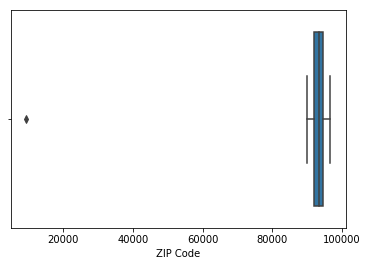

In [4]:
sns.boxplot(bank_df['ZIP Code'])

### We can see there is one ZIP code value (9307) which is an outlier as it is not a 5-digit code and may be a data entry error. Setting it to 93070 before we create additional features for the ZIP codes.

In [5]:
# bank_df['ZIP Code'] = bank_df['ZIP Code'].replace({9307:93070}, inplace=True)
bank_df['ZIP Code'].replace(to_replace =9307.0, 
                            value =93070.0, inplace=True) 

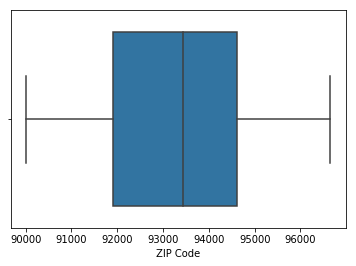

In [6]:
sns.boxplot(bank_df['ZIP Code'])

### Upon further investigation found that these ZIP codes belong to the state of California, where Southern California holds the range 90001-93600 and Northern California holds in between 93601-95961.
### So, creating an additional column if a person lives in South California or not.

In [7]:
bank_df['Lives_In_South_Cali'] = 0
bank_df['Lives_In_South_Cali'].loc[bank_df['ZIP Code'] <= 93600] = 1

C:\Users\swainr\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Lives_In_South_Cali
0,1,25,1,49,91107.0,4,1.6,1,0,0,1,0,0,0,1
1,2,45,19,34,90089.0,3,1.5,1,0,0,1,0,0,0,1
2,3,39,15,11,94720.0,1,1.0,1,0,0,0,0,0,0,0
3,4,35,9,100,94112.0,1,2.7,2,0,0,0,0,0,0,0
4,5,35,8,45,91330.0,4,1.0,2,0,0,0,0,0,1,1


### As Income is Annual and CCAvg is Monthly, creating additional column for Monthly Income

In [9]:
bank_df['Mo_Income'] = bank_df['Income']/12.
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Lives_In_South_Cali,Mo_Income
0,1,25,1,49,91107.0,4,1.6,1,0,0,1,0,0,0,1,4.083333
1,2,45,19,34,90089.0,3,1.5,1,0,0,1,0,0,0,1,2.833333
2,3,39,15,11,94720.0,1,1.0,1,0,0,0,0,0,0,0,0.916667
3,4,35,9,100,94112.0,1,2.7,2,0,0,0,0,0,0,0,8.333333
4,5,35,8,45,91330.0,4,1.0,2,0,0,0,0,0,1,1,3.750000


## Q2 Study the data distribution in each attribute, share your findings. (5 points)

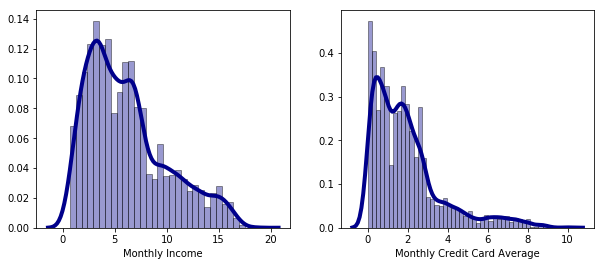

In [10]:
# Plot kde plots for Monthly Income and CCAvg
f, axes = plt.subplots(1,2, figsize=(10,4))

sns.distplot(bank_df['Mo_Income'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0], axlabel='Monthly Income')
sns.distplot(bank_df['CCAvg'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1], axlabel='Monthly Credit Card Average')

### We can see that both of have similar distribution and are right skewed.

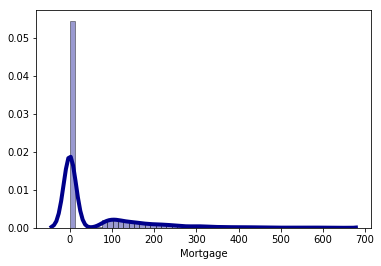

In [11]:
# Plot kde plots for Mortage
sns.distplot(bank_df['Mortgage'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### We observe that a lot of customers do not have a mortage. The ones who do typically have a mortgage in the range 50-300k.

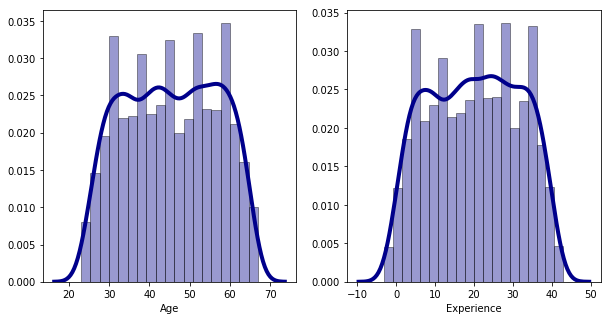

In [12]:
# Plot kde plots for Age and Experience
f, axes = plt.subplots(1,2, figsize=(10,5))

sns.distplot(bank_df['Age'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0])
sns.distplot(bank_df['Experience'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1])


### Age and Experience also have a similar distribution as expected.

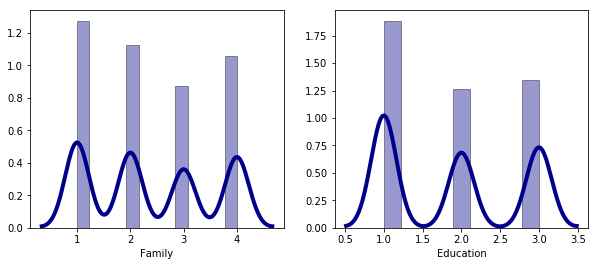

In [13]:
# Plot kde plots for Family and Education
f, axes = plt.subplots(1,2, figsize=(10,4))

sns.distplot(bank_df['Family'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0])
sns.distplot(bank_df['Education'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1])

### There are almost equal density for each category except for family of 3.
### Customers with Education Level 1 are the highest followed by similar density for Level 2 & 3.

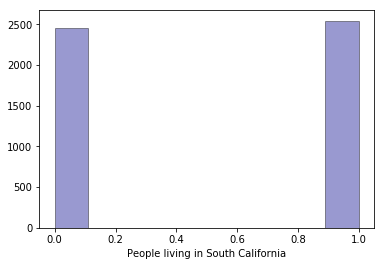

In [14]:
# Plot kde plots for customers who live or not in South California based on the ZIP Codes

sns.distplot(bank_df['Lives_In_South_Cali'], hist=True, kde=False, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, axlabel='People living in South California')

### There is almost equal density of customers living or not living in South California.

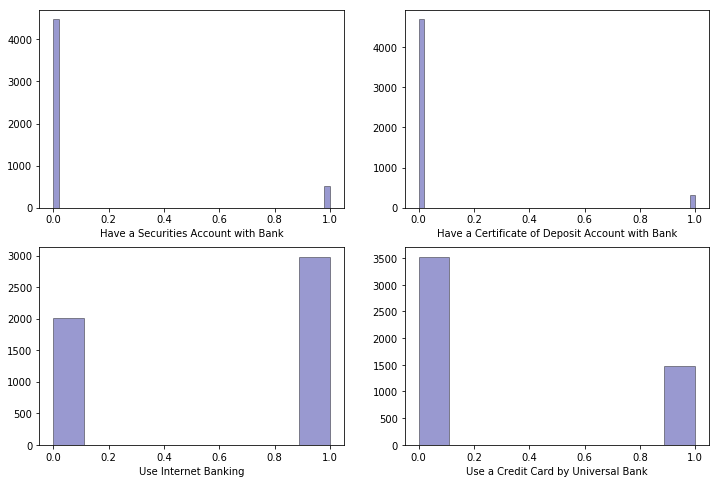

In [15]:
# Plot kde for rest of the attributes (Securities Account, CD Account, Online, CreditCard)

# Plot kde plots for Monthly Income and CCAvg
#f, axes = plt.subplots(2,2)
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
#ax1 = fig.add_subplot(211)
#ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(221)
#ax4 = fig.add_subplot(222)
sns.distplot(bank_df['Securities Account'], hist=True, kde=False, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axarr[0][0], axlabel='Have a Securities Account with Bank')
sns.distplot(bank_df['CD Account'], hist=True, kde=False, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axarr[0][1], axlabel='Have a Certificate of Deposit Account with Bank')
sns.distplot(bank_df['Online'], hist=True, kde=False, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axarr[1][0], axlabel='Use Internet Banking')
sns.distplot(bank_df['CreditCard'], hist=True, kde=False, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axarr[1][1], axlabel='Use a Credit Card by Universal Bank')

### Here we observe that a lot of customers do not have a Securities Account or/and Certificate of Deposit Account with the bank.

### Higher number of customers use Internet Banking Services and/or use a Credit Card by Universal Bank.

# Q3 Get the target column distribution. Your comments

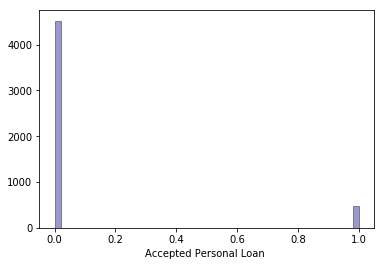

In [16]:
# Finally, plot the kde plot of Outcome (if they took a Personal Loan or not)

sns.distplot(bank_df['Personal Loan'], hist=True, kde=False, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, axlabel='Accepted Personal Loan ')

### Around 10% of the customers accepted the personal loan

# Q4 Split the data into training and test set in the ratio of 70:30 respectively

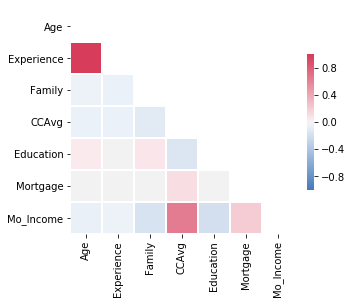

In [17]:
# Before creating features lets check the correlation between continuos features

all_cols = list(bank_df.columns.values)
to_remove = ['ID', 'Income', 'ZIP Code', 'Securities Account', 'CD Account', 'Online', 'CreditCard', 'Lives_In_South_Cali', 'Personal Loan']
corr_cols = []
for col in all_cols:
    if col not in to_remove:
        corr_cols.append(col)


# Do a heatmap for the lower triangle as both upper and lower triangles are symmtrical

# Compute the correlation matrix
corr = bank_df[corr_cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 5, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
# Checking Association/Correlation between Categorical Features and the Target (Categorical) using Phi Coefficient

corrcoef = matthews_corrcoef(bank_df['Personal Loan'], bank_df['Securities Account'])
print("Correlation coef of Personal Loan with Securities Account is %0.3f" %corrcoef)

corrcoef = matthews_corrcoef(bank_df['Personal Loan'], bank_df['CD Account'])
print("Correlation coef of Personal Loan with CD Account is %0.3f" %corrcoef)

corrcoef = matthews_corrcoef(bank_df['Personal Loan'], bank_df['Online'])
print("Correlation coef of Personal Loan with Online is %0.3f" %corrcoef)

corrcoef = matthews_corrcoef(bank_df['Personal Loan'], bank_df['CreditCard'])
print("Correlation coef of Personal Loan with CreditCard is %0.3f" %corrcoef)

corrcoef = matthews_corrcoef(bank_df['Personal Loan'], bank_df['Lives_In_South_Cali'])
print("Correlation coef of Personal Loan with Lives_In_South_Cali is %0.3f" %corrcoef)

Correlation coef of Personal Loan with Securities Account is 0.022
Correlation coef of Personal Loan with CD Account is 0.316
Correlation coef of Personal Loan with Online is 0.006
Correlation coef of Personal Loan with CreditCard is 0.003
Correlation coef of Personal Loan with Lives_In_South_Cali is 0.002


### 1. Between Continuos Features, we can see that there is an extremely high correlation between Age and Experience, so we can drop one of them to reduce dimensions.
### 2. Between Categorical Features and Categorical Target, we did not find any strong association. Still we will keep the features as we will be using various models.
### 3. To check assoication/correlation between Continuos Features and Categorical Target, we are performing Logistic Regression and its accuracy should give us an idea how strongly correlated they are.

In [19]:
# Create Features and Target and Split into 70:30

X = bank_df.drop(columns=['ID', 'Experience', 'Income', 'ZIP Code', 'Personal Loan'])
Y = bank_df['Personal Loan']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101, stratify=Y)

# Q5 Use different classification models (Logistic, K-NN and Naïve Bayes) to predict the likelihood of a liability customer buying personal loans (15 points)

### Logistic Regression

In [20]:
# Build and Fit Logistic Regression Model using Hyper Tuning

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg   = LogisticRegression()
logreg_cv= GridSearchCV(logreg, grid, cv=10, n_jobs=-1)
logreg_cv.fit(x_train, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy : %0.3f" %(logreg_cv.best_score_))

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.951


In [21]:
# Prediction

y_predict_test_logreg = logreg_cv.predict(x_test)
y_predict_train_logreg = logreg_cv.predict(x_train)

### KNN Classification

In [22]:
# Scale the features

X_scaled       = stats.zscore(X)
x_train_scaled = stats.zscore(x_train)
x_test_scaled  = stats.zscore(x_test)

In [23]:
# Build and Fit KNN Model using Hyper Tuning
grid={'n_neighbors' : [3,5,7,11,15,19],  'weights' : ['uniform', 'distance'], 'metric' : ['euclidean', 'manhattan']}
KNNclf    = KNeighborsClassifier()
KNNclf_cv = GridSearchCV(KNNclf, grid, cv=10, n_jobs=-1)
KNNclf_cv.fit(x_train_scaled, y_train)

print("tuned hpyerparameters :(best parameters) ",KNNclf_cv.best_params_)
print("accuracy : %0.3f" %(KNNclf_cv.best_score_))

tuned hpyerparameters :(best parameters)  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
accuracy : 0.959


In [24]:
# Prediction

y_predict_test_KNNclf = KNNclf_cv.predict(x_test_scaled)
y_predict_train_KNNclf = KNNclf_cv.predict(x_train_scaled)

### Naive-Bayes Classification

In [25]:
# Build and Fit Naive Bayes Model. There are no Hyper Parameters to tune here.

NBclf = GaussianNB()
NBclf.fit(x_train, y_train)


GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
# Prediction

y_predict_test_NBclf = NBclf.predict(x_test)
y_predict_train_NBclf = NBclf.predict(x_train)

# Q6 Print the confusion matrix for all the above models (5 points)

### Logistic Regression

In [27]:
# Print Confusion Matrix

print(confusion_matrix(y_test, y_predict_test_logreg))

[[1337   19]
 [  52   92]]


In [28]:
# Print classification matrix

print(classification_report(y_test,y_predict_test_logreg))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1356
           1       0.83      0.64      0.72       144

   micro avg       0.95      0.95      0.95      1500
   macro avg       0.90      0.81      0.85      1500
weighted avg       0.95      0.95      0.95      1500



In [29]:
# Print AUC Score

kfold = KFold(n_splits=10, random_state=101)
scoring = 'roc_auc'
logregclf   = LogisticRegression(C=10.0, penalty='l2')
results = cross_val_score(logregclf, X, Y, cv=kfold, scoring=scoring)
print("AUC: %0.3f" %(results.mean()), "(%0.3f)" %(results.std()))

AUC: 0.958 (0.013)


In [30]:
# Print Accuracy Score

print("Train accuracy is %0.3f" %(accuracy_score(y_train,y_predict_train_logreg)))
print("Test accuracy is %0.3f" %(accuracy_score(y_test,y_predict_test_logreg)))

Train accuracy is 0.952
Test accuracy is 0.953


### KNN Classifier

In [31]:
# Print Confusion Matrix

print(confusion_matrix(y_test, y_predict_test_KNNclf))

[[1348    8]
 [  63   81]]


In [32]:
# Print classification matrix

print(classification_report(y_test,y_predict_test_KNNclf))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1356
           1       0.91      0.56      0.70       144

   micro avg       0.95      0.95      0.95      1500
   macro avg       0.93      0.78      0.83      1500
weighted avg       0.95      0.95      0.95      1500



In [33]:
# Print AUC Score

kfold = KFold(n_splits=10, random_state=101)
scoring = 'roc_auc'
KNNclf   = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='distance')
results = cross_val_score(KNNclf, X_scaled, Y, cv=kfold, scoring=scoring)
print("AUC: %0.3f" %(results.mean()), "(%0.3f)" %(results.std()))

AUC: 0.908 (0.015)


In [34]:
# Print Accuracy Score

print("Train accuracy is %0.3f" %(accuracy_score(y_train,y_predict_train_KNNclf)))
print("Test accuracy is %0.3f" %(accuracy_score(y_test,y_predict_test_KNNclf)))

Train accuracy is 1.000
Test accuracy is 0.953


### Naive Bayes

In [35]:
# Print Confusion Matrix

print(confusion_matrix(y_test, y_predict_test_NBclf))

[[1233  123]
 [  65   79]]


In [36]:
# Print classification matrix

print(classification_report(y_test,y_predict_test_NBclf))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1356
           1       0.39      0.55      0.46       144

   micro avg       0.87      0.87      0.87      1500
   macro avg       0.67      0.73      0.69      1500
weighted avg       0.90      0.87      0.88      1500



In [37]:
# Print AUC Score

kfold = KFold(n_splits=10, random_state=101)
scoring = 'roc_auc'
NBclf = GaussianNB()
results = cross_val_score(NBclf, X, Y, cv=kfold, scoring=scoring)
print("AUC: %0.3f" %(results.mean()), "(%0.3f)" %(results.std()))

AUC: 0.926 (0.011)


In [38]:
# Print Accuracy Score

print("Train accuracy is %0.3f" %(accuracy_score(y_train,y_predict_train_NBclf)))
print("Test accuracy is %0.3f" %(accuracy_score(y_test,y_predict_test_NBclf)))

Train accuracy is 0.884
Test accuracy is 0.875


# Q7 Give your reasoning on which is the best model in this case and why it performs better? (5 points)

###  By evaulating all the models with a variety of metrics, I conclude the following:
###  1. Out of the three models, Naive Bayes had the least accuracy, AUC score and Precision/Recall.
###  2. Between Logistic and KNN, they have similar precision and recall but Logistic is the best model as it has the highest AUC score and also very good test and train accuracy. KNN's train accuracy tells us that it is overfitting the data.
###  3. I think Logistic performed the best because there must a strong correlation between the Categorical Target and the Continuous Features which we intended to verify while finding the correlation earlier.
